# Лабораторная работа 5

В ходе работы выполняется несколько заданий.
1. В прилагаемом  файле weather.csv содержатся данные многолетних наблюдений температуры. Усреднив результаты измерений, с помощью частотной фильтрации нужно, применив отсечение по некоторому порогу спектральной плотности мощности, убрать посторонние шумы и определить регулярный цикл с которым температура на планете меняется. Ответ, в принципе, известен, это 11-летний цикл активности солнца. В этой работе можно его подтвердить численно.

2. Используя образец, выполнить частотную фильтрацию изображения dog2.jpg

3. Опционально (не обязательно), по предоставленному в курсе образцу, выполнить выравнивание повернутого под некоторым углом текстового изображения.

## Часть 1. Погода

Text(0.5, 1.0, 'Годовое колебание средней температуры на всех датчиках в среднем')

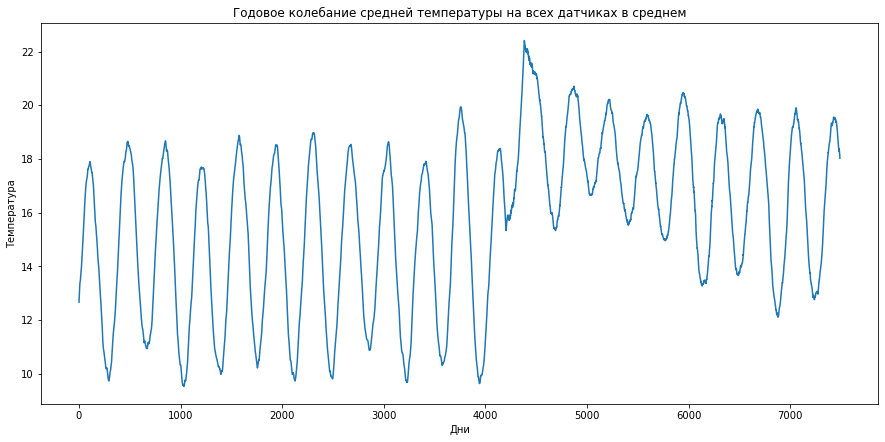

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

weather = pd.read_csv('weather.csv', delimiter=',')

#Загрузка максимальных значений температур в сводную таблицу
tmax = weather.pivot(index = 'STATION', columns = 'DATE', values = 'TMAX')
max_num = tmax.to_numpy()
max_num = max_num.astype(float)/10 #Масштабирование
max_num = np.where(max_num<-70, np.NAN, max_num) #Слишком маленькие числа становятся NaN
max_num = np.where(max_num>70, np.NAN, max_num) #Слишком большие числа становятся NaN

#Загрузка минимальных значений температур в сводную таблицу
tmin = weather.pivot(index = 'STATION', columns = 'DATE', values = 'TMIN')
min_num = tmin.to_numpy()
min_num = min_num.astype(float)/10 #Масштабирование
min_num = np.where(min_num<-70, np.NAN, min_num) #Слишком маленькие числа становятся NaN
min_num = np.where(min_num>70, np.NAN, min_num) #Слишком большие числа становятся NaN

#Нахождение средней температуры для каждой даты и каждого датчика
mid = (max_num + min_num)/2

#Усреднение показаний всех датчиков
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    medium = np.nanmean(mid, axis = 0)

#Замена в усредненных показаниях значений NaN значениями np.nanmean(medium)
medium = np.where(np.isnan(medium), np.nanmean(medium), medium)

#КИХ-фильтрация показаний
fir = np.ones(180)/180
m = np.convolve(medium, fir, mode='valid') 

#Построение графика
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(m)
ax.set_xlabel("Дни")
ax.set_ylabel("Температура")
ax.set_title('Годовое колебание средней температуры на всех датчиках в среднем')

### Графики средней температуры всех датчиков

In [2]:
med = np.zeros(np.shape(mid))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i in range(61):
        med[i,:] = np.where(np.isnan(mid[i,:]), np.nanmean(mid[i,:]), mid[i,:])

Text(0.5, 1.0, 'Графики средней температуры всех датчиков')

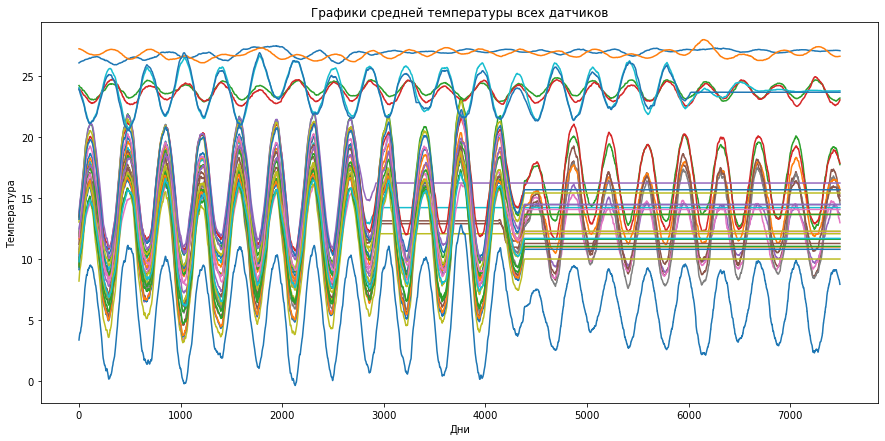

In [3]:
plt.figure(figsize=(15, 7))
for j in range(61):
    figure = plt.plot(np.convolve(med[j,:], fir, mode='valid'))
plt.xlabel("Дни")
plt.ylabel("Температура")
plt.title('Графики средней температуры всех датчиков')

## Часть 2. Частотная фильтрация изображения

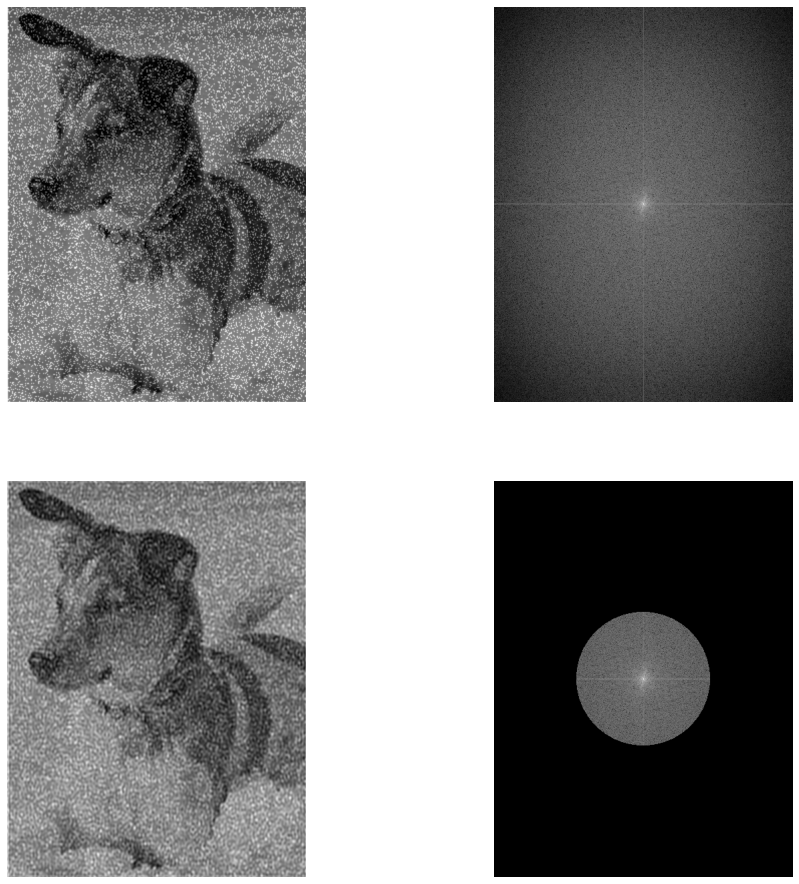

In [4]:
from matplotlib.image import imread
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams.update({'font.size': 18})
A = imread('dog2.jpg') # чтение изображения из файла
B = np.mean(A, -1); # Преобразование цветного изображения в черно-белое

Bt = np.fft.fft2(B) # получение образа изображения в частотной области с помощью двумерного FFT
Btshift = np.fft.fftshift(Bt) # Смещение нулевой частоты в центр
F = np.log(np.abs(Btshift)+1) # Расчет модулей амплитуд и преобразование к логарифмическому виду

fig,axs = plt.subplots(2,2) # Создание области рисования для 4 рисунков

axs[0,0].imshow(B,cmap='gray') # вывод изображения искаженного шумом
axs[0,0].axis('off')

axs[0,1].imshow(F,cmap='gray') # вывод частотного образа для этого изображения
axs[0,1].axis('off')

nx,ny = B.shape # определение размеров изображения
X,Y = np.meshgrid(np.arange(-ny/2+1,ny/2+1),np.arange(-nx/2+1,nx/2+1)) # создание матрицы координат для изображения
R2 = np.power(X,2) + np.power(Y,2) # расчет расстояния ху
ind = R2 < 100**2 # создание булевого массива для расстояний, не более некоторого порога
Btshiftfilt = Btshift * ind # низкочастотная фильтрация образа изображения в частотной области. Все компоненты, удаленные 
                            # на расстояние больше порогового, обнуляются
Ffilt = np.log(np.abs(Btshiftfilt)+1) # Получение логарифмического представления модулей амплитуд частотного образа

axs[1,1].imshow(Ffilt,cmap='gray') # вывод полученного частотного представления
axs[1,1].axis('off')

Btfilt = np.fft.ifftshift(Btshiftfilt) # Сдвиг частотного образа в обратную сторону
Bfilt = np.fft.ifft2(Btfilt).real # Обратное Фурье преобразование и выделение реальной части
axs[1,0].imshow(Bfilt,cmap='gray') # вывод отфильтрованного изображения
axs[1,0].axis('off')

plt.show()

## Часть 2.1. Медианная фильтрация изображения

Низкочастотная фильтрация практически не дала результатов. Попробуем использовать медианный фильтр

In [5]:
from scipy.signal import medfilt2d
C = medfilt2d(B, kernel_size=5)

(-0.5, 446.5, 592.5, -0.5)

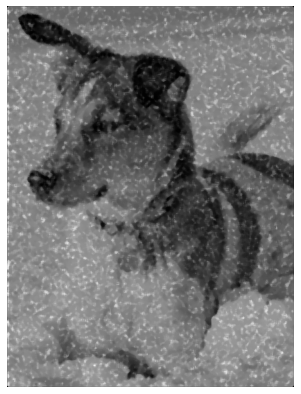

In [7]:
fig,axs = plt.subplots() # Создание области рисования для 4 рисунков

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams.update({'font.size': 18})

axs.imshow(C,cmap='gray') # вывод изображения искаженного шумом
axs.axis('off')
